In [2]:
import pandas as pd
import matplotlib.pyplot  as plt
import os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
dirname = os.path.join(os.path.abspath(os.curdir), 'data', 'underwork')

raw_data = {"3":(), "5":(), "8":(), "10":(), "14":(), "15":()}
for v in raw_data:
    tsdf_c = pd.read_csv(os.path.join(os.sep, dirname, v, 'calm_p.csv'))
    tsdf_w = pd.read_csv(os.path.join(os.sep, dirname, v,  'work_p.csv'))
    tsdf_m = pd.read_csv(os.path.join(os.sep, dirname, v, 'meta_p.csv'))
    raw_data[v] = (tsdf_c, tsdf_w, tsdf_m)

In [4]:
data = {"3":(), "5":(), "8":(), "10":(), "14":(), "15":()}

for v in raw_data:
    calm = raw_data[v][0]
    work = raw_data[v][1]
    weight = raw_data[v][2].iloc[1]["values"]
    height = raw_data[v][2].iloc[2]["values"]
    calm['label'] = f"{v}_calm"
    calm["weight"] = weight
    calm["height"] = height
    calm["state"] = 0
    work['label'] = f"{v}_work"
    work["weight"] = weight
    work["height"] = height
    work["state"] = 1
    data[v] = (calm, work)

In [5]:
def data_split(ts, param, train_percentage=0.67):
    timeseries = ts[param].values.astype('float32')
    train_size = int(len(timeseries) * train_percentage)
    train, test = timeseries[:train_size], timeseries[train_size:]
    return train, test, timeseries

In [6]:
import torch
 
def create_dataset(dataset, lookback):
    X, Y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        Y.append(target)
    return torch.tensor(X), torch.tensor(Y)

In [7]:
ts = pd.DataFrame()

for v in data:
   calm = data[v][0]
   work = data[v][1]
   ts = pd.concat([ts, calm, work], sort=False, axis=0)

ts = ts[(ts['Time'] >= 12.0) & (ts['Time']  < 60.0)]
ts['Time'] = pd.to_datetime(np.round(ts['Time']*1e3), unit='s')
ts = ts.set_index('Time')

ts

,1,2,3,4,5,6,label,weight,height,state
Time,,,,,,,,,,
1970-01-01 03:20:00,1.174719,-0.619266,-0.268312,2.123137,1.772549,-0.443593,3_calm,76.0,187.0,0
1970-01-01 03:20:01,1.175895,-0.616913,-0.268704,2.121569,1.773725,-0.442809,3_calm,76.0,187.0,0
1970-01-01 03:20:02,1.176679,-0.616521,-0.269880,2.120784,1.774510,-0.443201,3_calm,76.0,187.0,0
1970-01-01 03:20:03,1.177856,-0.616521,-0.271841,2.120392,1.776078,-0.443985,3_calm,76.0,187.0,0
1970-01-01 03:20:04,1.178640,-0.618090,-0.274978,2.120392,1.777647,-0.446338,3_calm,76.0,187.0,0
...,...,...,...,...,...,...,...,...,...,...
1970-01-01 16:39:54,1.629587,-0.226354,-0.785920,1.689020,2.248235,-0.505941,15_work,110.0,175.0,1
1970-01-01 16:39:55,1.629587,-0.226354,-0.785920,1.689020,2.248235,-0.505941,15_work,110.0,175.0,1
1970-01-01 16:39:56,1.629587,-0.226354,-0.785920,1.689020,2.248235,-0.505941,15_work,110.0,175.0,1


In [8]:
len(ts.index.unique()), len(ts.index) / 12

(47999, 47999.0)

array([         0, 1000000000], dtype='timedelta64[ns]')

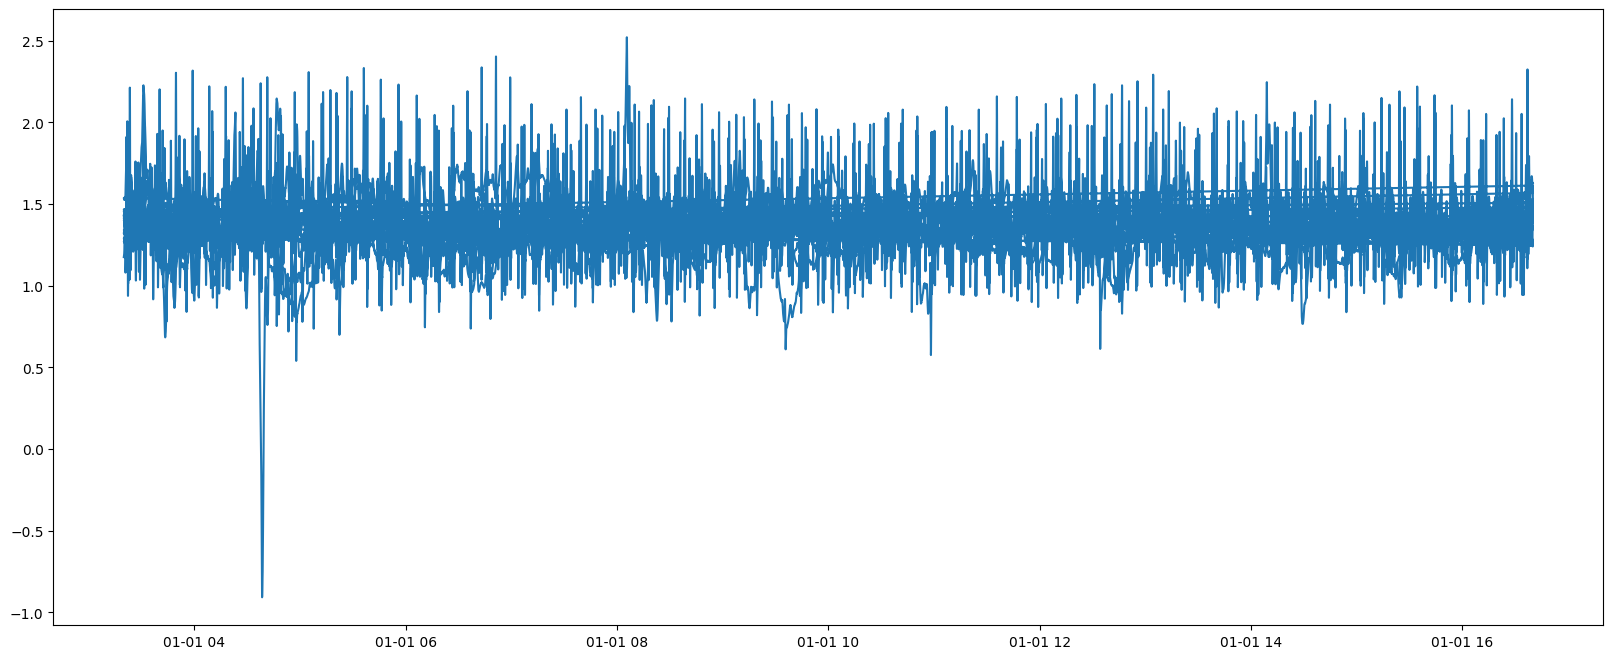

In [9]:
plt.figure(figsize=(20, 8))
plt.plot(ts.index, ts['1'])

np.unique(np.diff(ts.index.sort_values().to_numpy()))

In [10]:
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from gluonts.torch import DeepAREstimator

c:\VSCodeProjects\TimeSeries\.venv\lib\site-packages\gluonts\json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [11]:
torch.cuda.is_available()

True

In [15]:
ds =  PandasDataset.from_long_dataframe(ts, target='1', freq='S', item_id='label')
ds

PandasDataset<size=12, freq=S, num_feat_dynamic_real=0, num_past_feat_dynamic_real=0, num_feat_static_real=0, num_feat_static_cat=0, static_cardinalities=[]>

In [64]:
offset = 10000 # 3 sec
training_data, test_gen = split(ds, offset=-offset)
test_data = test_gen.generate_instances(prediction_length=3000)

In [65]:
model = DeepAREstimator(
    prediction_length=offset, 
    freq=ds.freq, 
    trainer_kwargs={"max_epochs": 5}
).train(training_data)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


c:\VSCodeProjects\TimeSeries\.venv\lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params | In sizes                                                               | Out sizes      
---------------------------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 25.1 K | [[1, 1], [1, 1], [1, 10181, 7], [1, 10181], [1, 10181], [1, 10000, 7]] | [1, 100, 10000]
---------------------------------------------------------------------------------------------------------------------------------
25.1 K    Trainable params
0         Non-trainable params
25.1 K    Total params
0.100     Total estimated model params size (MB)


Epoch 0: |          | 50/? [00:37<00:00,  1.33it/s, v_num=36, train_loss=0.519]

Epoch 0, global step 50: 'train_loss' reached 0.51869 (best 0.51869), saving model to 'c:\\VSCodeProjects\\TimeSeries\\Lab-12\\lightning_logs\\version_36\\checkpoints\\epoch=0-step=50.ckpt' as top 1


Epoch 1: |          | 50/? [00:36<00:00,  1.37it/s, v_num=36, train_loss=-.832]

Epoch 1, global step 100: 'train_loss' reached -0.83189 (best -0.83189), saving model to 'c:\\VSCodeProjects\\TimeSeries\\Lab-12\\lightning_logs\\version_36\\checkpoints\\epoch=1-step=100.ckpt' as top 1


Epoch 2: |          | 50/? [00:36<00:00,  1.39it/s, v_num=36, train_loss=-1.25]

Epoch 2, global step 150: 'train_loss' reached -1.24567 (best -1.24567), saving model to 'c:\\VSCodeProjects\\TimeSeries\\Lab-12\\lightning_logs\\version_36\\checkpoints\\epoch=2-step=150.ckpt' as top 1


Epoch 3: |          | 50/? [00:34<00:00,  1.46it/s, v_num=36, train_loss=-1.44]

Epoch 3, global step 200: 'train_loss' reached -1.44335 (best -1.44335), saving model to 'c:\\VSCodeProjects\\TimeSeries\\Lab-12\\lightning_logs\\version_36\\checkpoints\\epoch=3-step=200.ckpt' as top 1


Epoch 4: |          | 50/? [00:34<00:00,  1.46it/s, v_num=36, train_loss=-1.25]

Epoch 4, global step 250: 'train_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: |          | 50/? [00:34<00:00,  1.46it/s, v_num=36, train_loss=-1.25]


In [66]:
forecasts = list(model.predict(test_data.input))

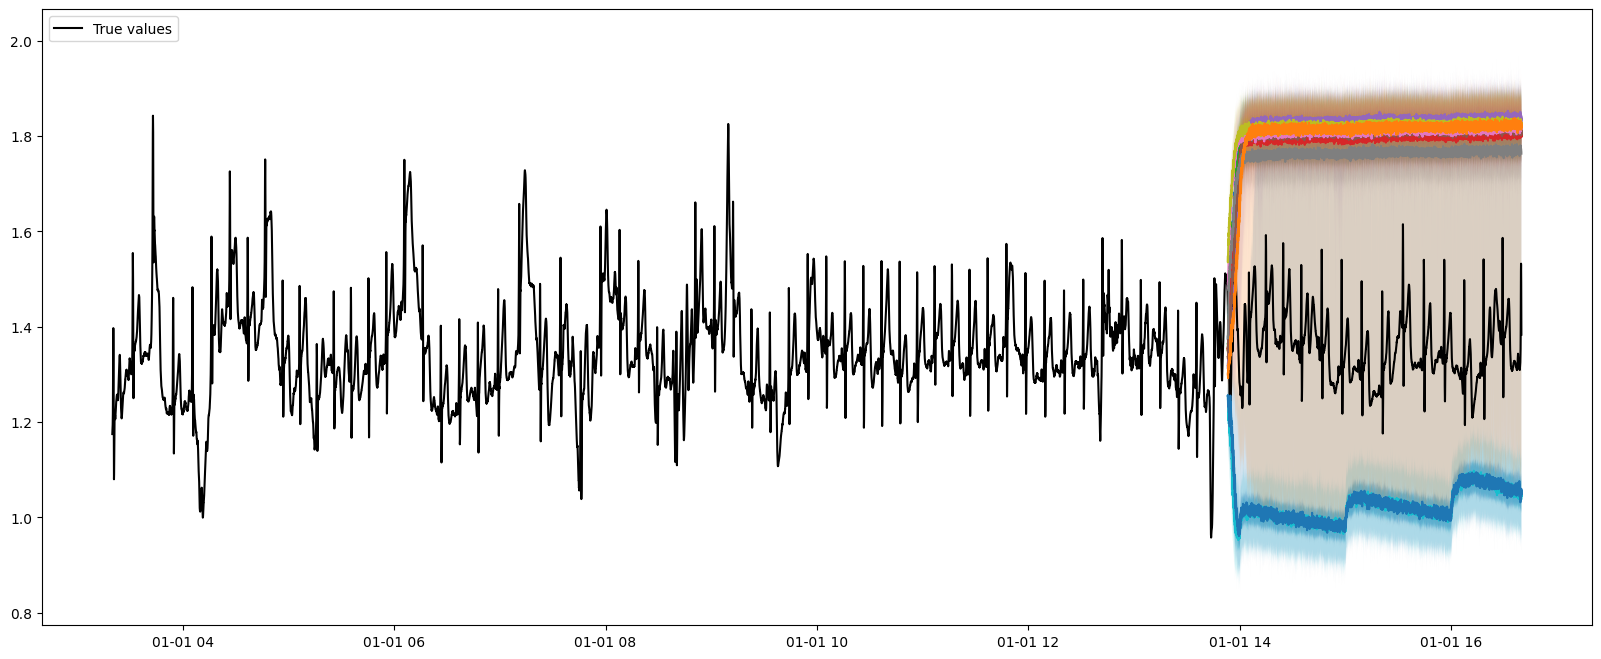

In [67]:
# Короче, что-то не то. Нужно переделать
d = ts[ts['label'] == '3_calm']

plt.figure(figsize=(20, 8))
plt.plot(d.index, d['1'], color="black")
for forecast in forecasts:
  forecast.plot()
plt.legend(["True values"], loc="upper left")
plt.show()